In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# SAM 3 Agent

A single gpu with 80 GB memory is good to run this demo.

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_agent.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>

## Env Setup

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib scikit-learn
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook. If your card doesn't support it, try float16 instead
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# inference mode for the whole notebook. Disable if you need gradients
torch.inference_mode().__enter__()

In [6]:
import os

SAM3_ROOT = os.path.dirname(os.getcwd())
os.chdir(SAM3_ROOT)

# setup GPU to use -  A single GPU is good with the purpose of this demo
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
_ = os.system("nvidia-smi")

Wed Oct 29 22:43:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:97:00.0 Off |                    0 |
| N/A   28C    P0            115W /  700W |   73696MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## LLM Setup

In [7]:
LLM_CONFIGS = {
    # VLLM-served models
    "qwen2.5_7b": {
        "provider": "vllm",
        "model": "Qwen/Qwen2.5-VL-7B-Instruct",
    },
    "qwen2.5_72b": {
        "provider": "vllm",
        "model": "Qwen/Qwen2.5-VL-72B-Instruct",
    },
    "qwen3_235b": {
        "provider": "vllm",
        "model": "Qwen/Qwen3-VL-235B-A22B-Instruct",
    },
    "llama4_maverick": {
        "provider": "vllm",
        "model": "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
    },
    "llama4_scout": {
        "provider": "vllm",
        "model": "meta-llama/Llama-4-Scout-17B-16E-Instruct",
    },
    "gpt5": {
        "provider": "openai",
        "base_url": "https://api.openai.com/v1/",
        "model": "gpt-5",
    },
    "gemini_pro": {
        "provider": "gemini",
        "base_url": "https://generativelanguage.googleapis.com/v1beta/",
        "model": "gemini-2.5-pro",
    },
    "gemini_flash": {
        "provider": "gemini",
        "base_url": "https://generativelanguage.googleapis.com/v1beta/",
        "model": "gemini-2.5-flash",
    }
}

model = "qwen2.5_7b" # @param ["qwen2.5_7b,"qwen2.5_72b","llama4_maverick","llama4_scout","gpt5","gemini_pro","gemini_flash"] {"allow-input":true}
LLM_API_KEY = "DUMMY_API_KEY" # @param ["DUMMY_API_KEY"]

#model = "gpt5"
#LLM_API_KEY = "YOUR_OPENAI_API_KEY"

#model = "gemini_pro"
#LLM_API_KEY = "YOUR_GEMINI_API_KEY"


llm_config = LLM_CONFIGS[model]
llm_config["api_key"] = LLM_API_KEY
llm_config["name"] = model

## Setup vLLM server (optional)
This step is only required if you are using a model served by vLLM, skip this step if you are calling LLM using an API like Gemini and GPT.

* Install vLLM
  ```bash
    conda create -n vllm python=3.12
    pip install vllm==0.10.1
  ```
* Start vLLM server
  ```bash
    # qwen 2.5VL 7B
    vllm serve Qwen/Qwen2.5-VL-7B-Instruct --tensor-parallel-size 1 --allowed-local-media-path / --enforce-eager --port 8001
    
    # qwen 2.5VL 72B
    vllm serve Qwen/Qwen2.5-VL-72B-Instruct --tensor-parallel-size 8 --allowed-local-media-path / --enforce-eager --port 8001
    
    # Llama 4 Maverick
    VLLM_DISABLE_COMPILE_CACHE=1 vllm serve meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8   --tensor-parallel-size 8   --max-model-len 430000 --allowed-local-media-path / --port 8001
    
    # Llama 4 Scout
    VLLM_DISABLE_COMPILE_CACHE=1 vllm serve meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8   --tensor-parallel-size 4   --max-model-len 30000 --allowed-local-media-path / --max-num-seqs 1 --port 8001
  ```

In [8]:
if llm_config["provider"] == "vllm":
    LLM_SERVER_URL = "http://0.0.0.0:8001/v1"  # replace this with your vLLM server address as needed
else:
    LLM_SERVER_URL = llm_config["base_url"]

## Build SAM3 Model

In [9]:
from sam3 import build_sam3_image_model

bpe_path = os.path.join(SAM3_ROOT, "assets/bpe_simple_vocab_16e6.txt.gz")
checkpoint_path = "/checkpoint/sam3/chayryali/omnivision_onevision/config/experiments/chayryali/sam3v1_stage3/final/paper_launch_model_oct/launch_stage3_v2.yaml/0/checkpoints/checkpoint.pt"

model = build_sam3_image_model(bpe_path=bpe_path, checkpoint_path=checkpoint_path).cuda()

In [10]:
from sam3.model.sam3_image_processor import Sam3Processor

processor = Sam3Processor(model, confidence_threshold=0.5)

## Run SAM3 Agent Inference

In [11]:
from functools import partial
from IPython.display import display, Image
from sam3.agent.client_llm import send_generate_request as send_generate_request_orig
from sam3.agent.inference import call_sam_service as call_sam_service_orig
from sam3.agent.inference import run_single_image_inference

/storage/home/jielei/sam3/sam3/agent/agent_core.py:199: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (





--------------Processing single image with prompt: person wearing blue clothes--------------

Image: /storage/home/jielei/sam3/assets/images/test_image.jpg
Output directory: agent_output
SAM3 output dir: agent_output

Initial text prompt:

 person wearing blue clothes


Initial image path:

 /storage/home/jielei/sam3/assets/images/test_image.jpg
image_path /storage/home/jielei/sam3/assets/images/test_image.jpg
Calling model Qwen/Qwen2.5-VL-7B-Instruct...
Received response: ChatCompletionMessage(content='<think>There is only one image in the message history (the raw input image). Since there is only one image, I will follow the Scenario 1 instructions: \n1. Analyze: The image shows a group of children playing on a basketball court. Some of the children are wearing blue clothes, while others are wearing red and pink clothes.\n2. Think: Based on the understanding of the image and the previously stated rules for how I should understand the initial user input query, I need to ground the 

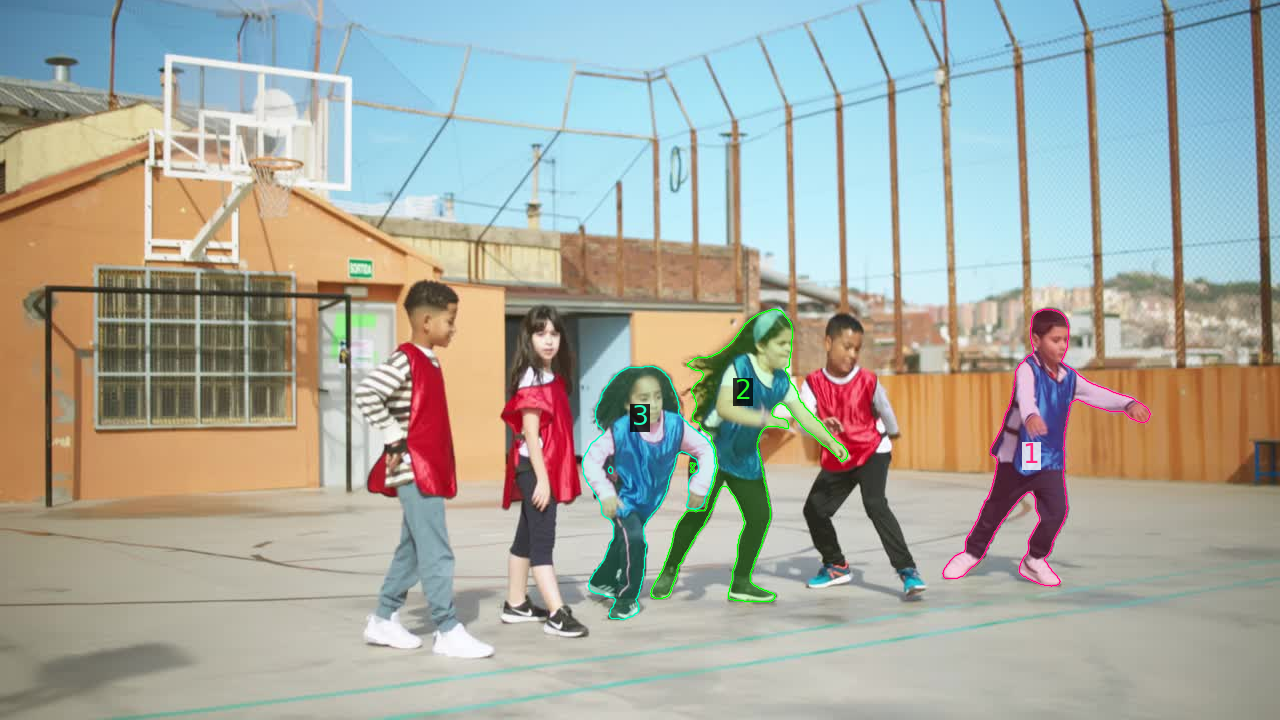

In [12]:
image = "assets/images/test_image.jpg"
prompt = "person wearing blue clothes"

image = os.path.abspath(image)
send_generate_request = partial(send_generate_request_orig, server_url=LLM_SERVER_URL, model=llm_config["model"], api_key=llm_config["api_key"])
call_sam_service = partial(call_sam_service_orig, sam3_processor=processor)

# Run single image inference
output_image_path = run_single_image_inference(image, prompt, llm_config, send_generate_request, call_sam_service)

# Display output
display(Image(filename=output_image_path))